# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [160]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json

from scipy.stats import linregress
from citipy import citipy
from pprint import pprint

from api_keys import weather_api_key
from api_keys import g_key

# Set output file path
output_file = "../output_files/cities_weather.csv"

# Set range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [161]:
# Creat empty lists for lat_lgn and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(low = -90.000, high = 90.000, size = 1500)
lngs = np.random.uniform(low = -180.000, high = 180.000, size = 1500)
lat_lngs = zip(lats, lngs)

# Find the closest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
# If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

print(f"There's %s cities to poll for weather." % len(cities))

There's 642 cities to poll for weather.


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [162]:
# Setup Query URL
base_url = "http://api.openweathermap.org/data/2.5/weather?appid="
api_key = weather_api_key
units = "imperial"
query_url = f"{base_url}{api_key}&units={units}&q="

In [163]:
# Create dictionary to store data from API calls
city_weather_data = {"City": [],
                     "Lat": [],
                     "Lng": [],
                     "Max Temp": [],
                     "Humidity": [],
                     "Cloudiness": [],
                     "Wind Speed": [],
                     "Country": [],
                     "Date": []}

# Loop thru the API call data to add the data retrieved into the dictionary
for i, city in enumerate(cities):
    city = requests.get(query_url + cities[i].replace(" ","&")).json()

    try:
        print(f"Processing city " + str(i) + ": " + city["name"])

        city_weather_data["City"].append(city["name"])
        city_weather_data["Lat"].append(city["coord"]["lat"])
        city_weather_data["Lng"].append(city["coord"]["lon"])
        city_weather_data["Max Temp"].append(city["main"]["temp_max"])
        city_weather_data["Humidity"].append(city["main"]["humidity"])
        city_weather_data["Cloudiness"].append(city["clouds"]["all"])
        city_weather_data["Wind Speed"].append(city["wind"]["speed"])
        city_weather_data["Country"].append(city["sys"]["country"])
        city_weather_data["Date"].append(city["dt"])

    except:
        print(f"Data retrieve failure. Skipping city instance...")
        pass
print("Data retrieval is completed.")

Processing city 0: Upernavik
Processing city 1: Saskylakh
Processing city 2: Rikitea
Processing city 3: Port
Processing city 4: Cabo
Processing city 5: Tipuani
Processing city 6: Faanui
Processing city 7: East
Processing city 8: Kralendijk
Processing city 9: Castro
Processing city 10: Hay-on-wye
Processing city 11: Cockburn
Data retrieve failure. Skipping city instance...
Processing city 13: Asău
Processing city 14: Constitución
Processing city 15: Ushuaia
Processing city 16: Saint-Philippe
Processing city 17: Kruisfontein
Processing city 18: Tsuyama
Data retrieve failure. Skipping city instance...
Processing city 20: Sitka
Processing city 21: Portland
Processing city 22: Clyde
Data retrieve failure. Skipping city instance...
Processing city 24: Atuona
Processing city 25: Eyl
Processing city 26: Kavieng
Processing city 27: Hermanus
Processing city 28: Vaini
Processing city 29: Neturhāt
Processing city 30: Mossamedes
Processing city 31: El Puerto de Santa María
Processing city 32: Hobar

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [164]:
# Export the city data into CSV
city_weather_df = pd.DataFrame(city_weather_data)
city_weather_df.to_csv(output_file, index = False)

# Display DataFrame
print(city_weather_df.head())

# Count the number of cities with data that were successfully pulled from API call
city_retrieved = city_weather_df["City"].count()
print(f"There's %s cities data retrieved out of {len(cities)} cities." % city_retrieved)

# Calculate successful rate
success_rate = round((city_retrieved / len(cities) * 100),2)
print(f"Success rate is: %s" % success_rate  + "%.")

        City      Lat       Lng  Max Temp  Humidity  Cloudiness  Wind Speed  \
0  Upernavik  72.7868  -56.1549     25.25        50          90        5.57   
1  Saskylakh  71.9167  114.0833     56.17        67         100        9.10   
2    Rikitea -23.1203 -134.9692     73.13        72          13       10.85   
3       Port  -7.0349   29.7638     83.10        33          73        2.21   
4       Cabo  -8.2833  -35.0333     80.53        61          88       11.90   

  Country        Date  
0      GL  1631369142  
1      RU  1631369142  
2      PF  1631369143  
3      CD  1631369144  
4      BR  1631369145  
There's 566 cities data retrieved out of 642 cities.
Success rate is: 88.16%.


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [165]:
# Test to make sure no city has humdity over 100%
test_stats = city_weather_df["Humidity"].describe()
print(test_stats)
print(f"Inspection result showing the maximum humidity value is 100%. Number of cities to analyze remains the same.")

count    566.000000
mean      67.300353
std       21.595351
min        7.000000
25%       55.250000
50%       71.000000
75%       85.000000
max      100.000000
Name: Humidity, dtype: float64
Inspection result showing the maximum humidity value is 100%. Number of cities to analyze remains the same.


#  Get the indices of cities that have humidity over 100%.

# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

In [166]:
# Creates variables for relevant table columns
lat = city_weather_df["Lat"]
max_temp = city_weather_df["Max Temp"]
humidity = city_weather_df["Humidity"]
cloudiness = city_weather_df["Cloudiness"]
wind_speed = city_weather_df["Wind Speed"]

In [167]:
# Define plotting function
def plot_scatter(ydata, ylbl, title, savefig):
    
    plt.scatter(lat, ydata, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")
    plt.title(title)
    plt.xlabel("Latitude")
    plt.ylabel(ylbl)
    plt.tight_layout()
    plt.grid(True)
    plt.savefig("../output_files/savefig")

## Latitude vs. Temperature Plot

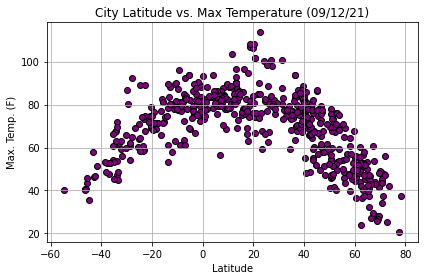

In [183]:
# Latitude vs. Temperature Plot
ylbl = "Max. Temp. (F)"
savefig = "Lat_Temp.png"
title = "City Latitude vs. Max Temperature (%s)" % time.strftime("%x")
plot_scatter(max_temp, ylbl, title, savefig)

## Latitude vs. Humidity Plot

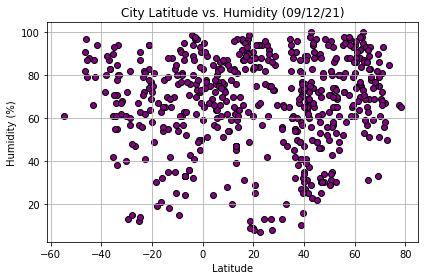

In [184]:
# Latitude vs. Humidity Plot
ylbl = "Humidity (%)"
savefig = "Lat_Humid.png"
title = "City Latitude vs. Humidity (%s)" % time.strftime("%x")
plot_scatter(humidity, ylbl, title, savefig)

## Latitude vs. Cloudiness Plot

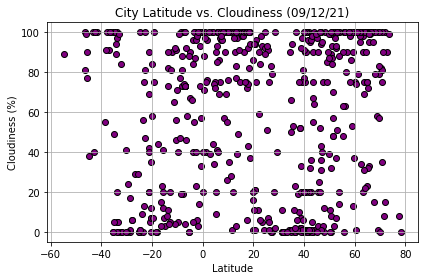

In [185]:
# Latitude vs. Cloudiness Plot
ylbl = "Cloudiness (%)"
savefig = "Lat_Cloud.png"
title = "City Latitude vs. Cloudiness (%s)" % time.strftime("%x")
plot_scatter(cloudiness, ylbl, title, savefig)

## Latitude vs. Wind Speed Plot

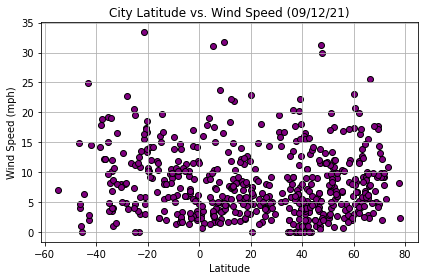

In [186]:
#Latitude vs. Wind Speed Plot
ylbl = "Wind Speed (mph)"
savefig = "Lat_Cloud.png"
title = "City Latitude vs. Wind Speed (%s)" % time.strftime("%x")
plot_scatter(wind_speed, ylbl, title, savefig)

## Linear Regression

In [172]:
# Create Northern Hemisphere DataFrames
northern_hemisphere = city_weather_df.loc[city_weather_df["Lat"] >= 0.0]
northern_hemisphere.reset_index(inplace = True)

# Create Southern Hemisphere DataFrames
southern_hemisphere = city_weather_df.loc[city_weather_df["Lat"] < 0.0]
southern_hemisphere.reset_index(inplace = True)

print(northern_hemisphere.head())
print(southern_hemisphere.head())

   index        City      Lat       Lng  Max Temp  Humidity  Cloudiness  \
0      0   Upernavik  72.7868  -56.1549     25.25        50          90   
1      1   Saskylakh  71.9167  114.0833     56.17        67         100   
2      7        East  65.0000  -15.0000     53.47        57         100   
3      8  Kralendijk  12.1500  -68.2667     87.78        70          20   
4     10  Hay-on-wye  52.0705   -3.1274     70.21        65          99   

   Wind Speed Country        Date  
0        5.57      GL  1631369142  
1        9.10      RU  1631369142  
2        5.57      IS  1631369147  
3       18.41      BQ  1631369148  
4       10.71      GB  1631369149  
   index     City      Lat       Lng  Max Temp  Humidity  Cloudiness  \
0      2  Rikitea -23.1203 -134.9692     73.13        72          13   
1      3     Port  -7.0349   29.7638     83.10        33          73   
2      4     Cabo  -8.2833  -35.0333     80.53        61          88   
3      5  Tipuani -15.5648  -68.0185     81.0

In [173]:
# Define plotting function
def plot_linear_regression(xdata, ydata, ylbl, lblpos, title, savefig):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(xdata, ydata)
    color = "orange"
    print(f"The r-squared is: {rvalue}")
    regress_values = xdata * slope + intercept
    line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))

    plt.scatter(xdata, ydata, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")
    plt.plot(xdata,regress_values, color)
    plt.annotate(line_eq, lblpos, fontsize = 15, color = color)
    plt.title(title)
    plt.xlabel("Latitude")
    plt.ylabel(ylbl)
    plt.tight_layout()
    plt.savefig("../output_files/savefig")

In [174]:
# Create variables for relevant table columns
nlat = northern_hemisphere["Lat"]
nmax_temp = northern_hemisphere["Max Temp"]
nhumidity = northern_hemisphere["Humidity"]
ncloudiness = northern_hemisphere["Cloudiness"]
nwind_speed = northern_hemisphere["Wind Speed"]

slat = southern_hemisphere["Lat"]
smax_temp = southern_hemisphere["Max Temp"]
shumidity = southern_hemisphere["Humidity"]
scloudiness = southern_hemisphere["Cloudiness"]
swind_speed = southern_hemisphere["Wind Speed"]

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: -0.7781241331549175


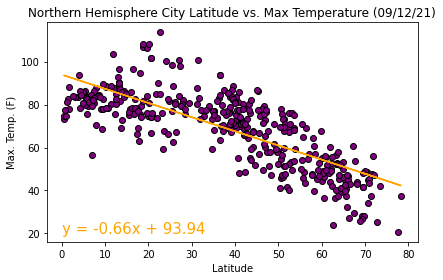

In [175]:
# Create Scatter Plot for Northern Hemisphere - Max Temp vs. Latitude Linear Regression
# And save graph as PNG
ylbl = "Max. Temp. (F)"
lblpos = (0, 20)
savefig = "NLat_Temp.png"
title = "Northern Hemisphere City Latitude vs. Max Temperature (%s)" % time.strftime("%x")
plot_linear_regression(nlat, nmax_temp, ylbl, lblpos, title, savefig)

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.7805780717512306


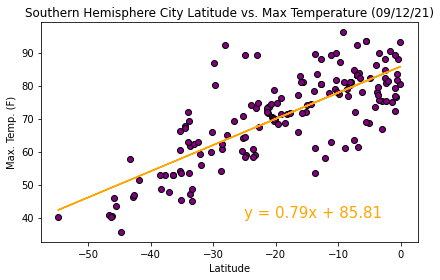

In [176]:
# Create Scatter Plot for Southern Hemisphere - Max Temp vs. Latitude Linear Regression
ylbl = "Max. Temp. (F)"
lblpos = (-25, 40)
savefig = "SLat_Temp.png"
title = "Southern Hemisphere City Latitude vs. Max Temperature (%s)" % time.strftime("%x")
plot_linear_regression(slat, smax_temp, ylbl, lblpos, title, savefig)

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.06220263196864497


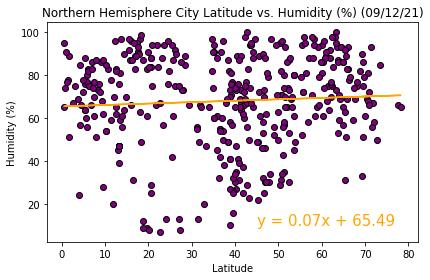

In [177]:
# Create Scatter Plot for Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression
ylbl = "Humidity (%)"
lblpos = (45, 10)
savefig = "NLat_Humid"
title = "Northern Hemisphere City Latitude vs. Humidity (%%) (%s)" % time.strftime("%x")
plot_linear_regression(nlat, nhumidity, ylbl, lblpos, title, savefig)

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: -0.14373041987076596


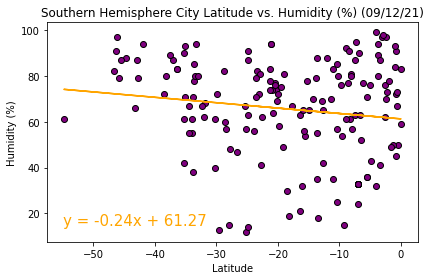

In [178]:
# Create Scatter Plot for Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression
ylbl = "Humidity (%)"
lblpos = (-55, 15)
savefig = "SLat_Humid"
title = "Southern Hemisphere City Latitude vs. Humidity (%%) (%s)" % time.strftime("%x")
plot_linear_regression(slat, shumidity, ylbl, lblpos, title, savefig)

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: -0.026525506527790385


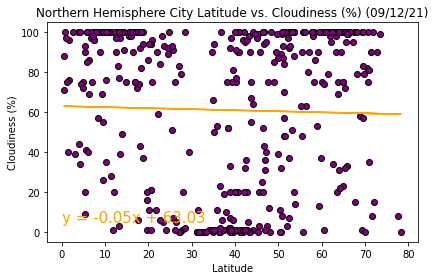

In [179]:
# Create Scatter Plot for Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression
ylbl = "Cloudiness (%)"
lblpos = (0, 5)
savefig = "NLat_Cloud"
title = "Northern Hemisphere City Latitude vs. Cloudiness (%%) (%s)" % time.strftime("%x")
plot_linear_regression(nlat, ncloudiness, ylbl, lblpos, title, savefig)

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.04846087820251522


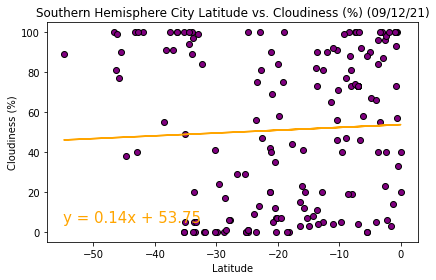

In [180]:
# Create Scatter Plot for Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression
ylbl = "Cloudiness (%)"
lblpos = (-55, 5)
savefig = "SLat_Cloud"
title = "Southern Hemisphere City Latitude vs. Cloudiness (%%) (%s)" % time.strftime("%x")
plot_linear_regression(slat, scloudiness, ylbl, lblpos, title, savefig)

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: 0.049660497533022124


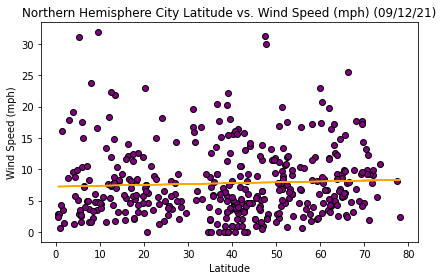

In [181]:
# Create Scatter Plot for Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression
ylbl = "Wind Speed (mph)"
lblpos = (0, 45)
savefig = "NLat_Wind"
title = "Northern Hemisphere City Latitude vs. Wind Speed (mph) (%s)" % time.strftime("%x")
plot_linear_regression(nlat, nwind_speed, ylbl, lblpos, title, savefig)

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: -0.17656829183564934


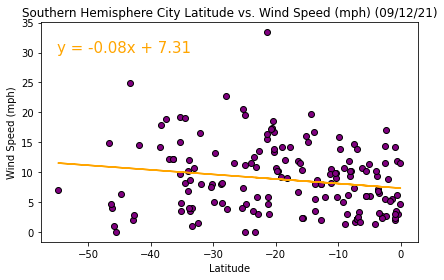

In [182]:
# Create Scatter Plot for Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression
ylbl = "Wind Speed (mph)"
lblpos = (-55, 30)
savefig = "SLat_Wind"
title = "Southern Hemisphere City Latitude vs. Wind Speed (mph) (%s)" % time.strftime("%x")
plot_linear_regression(slat, swind_speed, ylbl, lblpos, title, savefig)